# Introduction

In this project, our objective is to process and analyze a dataset of security alerts in order to extract meaningful insights and build a solid foundation for modeling......

It is often said that data science is composed of approximately 40% statistics, 40% computer science, and the remaining 20% business understanding. This final component is essential: before we attempt to build machine learning models or artificial intelligence systems, we must first understand the business domain — in this case, cybersecurity.
A strong understanding of the context allows us to make informed decisions, identify relevant patterns, and potentially uncover valuable insights that could significantly improve our models.

For that reason, we begin this project by examining and understanding our data in detail, including a thorough explanation of each column. Once the context is clear, we proceed to the exploratory data analysis.


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)  


In [171]:
path = r"C:\Users\F1302\Desktop\AlgoSecure\security_alerts_dataset.csv"
df = pd.read_csv(path, sep=",", encoding="utf-8", low_memory=False)
df.head(3)

,alert_id,timestamp,alert_type,severity,source_ip,destination_ip,affected_application,description,technical_indicator,status,event_count,user_involved,detection_tool,raw_output,cvss_score,cve_id,ports
0,ALERT-21ca6360,2025-03-19 08:42:15.688764,Malware Detection,High,45.76.12.145,10.0.0.21,Email Server,Port scan from 45.76.12.145 detected 8 open ports on 10.0.0.21,e67f227ab078285c12917af979dbbe32,New,2,NaN,Rustscan,"{\n ""host"": ""10.0.0.21"",\n ""ports"": [\n 21,\n 25,\n 1433,\n 80,\n 27017,\n 3306,\n 9200,\n 8443\n ],\n ""open_ports"": 8,\n ""scan_time"": ""122.52ms"",\n ""services"": [\n ""21/FTP"",\n ""25/SMTP"",\n ""1433/MSSQL"",\n ""80/HTTP"",\n ""27017/MongoDB"",\n ""3306/MySQL"",\n ""9200/Elasticsearch"",\n ""8443/HTTPS-Alt""\n ],\n ""rustscan_version"": ""2.1.1"",\n ""timestamp"": ""2025-04-02T08:41:01.782567""\n}",NaN,NaN,"21,25,1433,80,27017,3306,9200,8443"
1,ALERT-6c9ac310,2025-03-19 08:42:58.688764,DoS/DDoS,Low,89.23.45.181,10.0.0.184,Internal Portal,DoS/DDoS event detected from 89.23.45.181,b0b214938a9b7a13228b6f227676c28f,New,5,user398@company.com,EDR,NaN,NaN,NaN,NaN
2,ALERT-fdc937b2,2025-03-19 08:43:11.688764,Policy Violation,Low,45.76.12.162,172.16.1.55,VPN Service,Nuclei scan detected Jenkins Detect vulnerability on 172.16.1.55,36cc676b1c9d36aa727d3f06f59021e0,False Positive,1,user652@company.com,Nuclei,"{\n ""template"": ""jenkins-detect"",\n ""matcher-name"": ""jenkins-detect-detect"",\n ""severity"": ""low"",\n ""host"": ""172.16.1.55"",\n ""matched-at"": ""https://172.16.1.55/api/endpoint"",\n ""extracted-results"": [\n ""version: vulnerable-2.x""\n ],\n ""ip"": ""172.16.1.55"",\n ""timestamp"": ""2025-04-02T08:41:01.753512"",\n ""curl-command"": ""curl -X GET -H 'User-Agent: Mozilla/5.0' https://172.16.1.55/api/endpoint"",\n ""cvss-score"": ""0.8"",\n ""cve"": ""CVE-2020-8099""\n}",0.846068,CVE-2020-8099,443


By viewing the head:
Alert_id: looks like the primary key of the table (we will verify if all values are uniques)
Timestamp: Maybe is the date of the alert 
 

# Understunding the data

In [172]:
print(df.columns)
print(f"Shape of data: {df.shape}")

Index(['alert_id', 'timestamp', 'alert_type', 'severity', 'source_ip',
       'destination_ip', 'affected_application', 'description',
       'technical_indicator', 'status', 'event_count', 'user_involved',
       'detection_tool', 'raw_output', 'cvss_score', 'cve_id', 'ports'],
      dtype='object')
Shape of data: (5252, 17)


## Dataset Column Descriptions

This document provides a clear and concise explanation of each column in the security alert dataset.

---

**alert_id**  
Unique identifier for each alert. Used to reference or track a specific alert.

**timestamp**  
Date and time when the alert was generated by the detection tool.

**alert_type**  
Type of detected event, such as malware detection, phishing attempt, denial-of-service attack, etc.

**severity**  
The severity level assigned to the alert:  
- `Low`: Low risk  
- `Medium`: Moderate risk  
- `High`: High risk

**source_ip**  
The IP address from which the alert originated. Usually represents the potential attacker or external source.

**destination_ip**  
The internal IP address targeted by the alert — typically a device or service within the organization.

**affected_application**  
The name of the application, service, or system affected by the alert (e.g., email server, database, VPN service).

**description**  
Automatically generated text describing the detected event. It may be generic or semi-dynamic depending on the tool.

**technical_indicator**  
Technical fingerprint identifying the threat (e.g., a hash, signature, or rule ID).  
This may be duplicated across rows if the **same threat** is detected multiple times in different contexts.

**status**  
The current processing state of the alert:  
- `New`: Not yet reviewed  
- `Resolved`: Investigated and closed  
- `False Positive`: Considered irrelevant or harmless

**event_count**  
The number of similar events grouped into this single alert. Used to reflect how frequently or intensely the event occurred in a short time.

**user_involved**  
The internal user account (e.g., email) that was involved in or targeted by the alert. Usually represents the victim.

**detection_tool**  
The security tool or system that generated the alert (e.g., SIEM, EDR, Nuclei, Rustscan).

**raw_output**  
The unprocessed output from the detection tool, usually in JSON or log format. It contains technical details that may not be fully extracted into other columns.

**cvss_score**  
A standardized score (0 to 10) indicating the severity of a known vulnerability, based on the CVSS (Common Vulnerability Scoring System).

**cve_id**  
A public identifier for a documented vulnerability (in the format CVE-YYYY-XXXX). This allows linking to public vulnerability databases (e.g., CVE-2020-8099).

**ports**  
List of network ports associated with the alert. These may have been scanned, exploited, or simply observed in suspicious traffic.


In [173]:
df.info()
# From the output, we can say that, the timestamp column is in object format, we need to convert it to datetime format.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5252 entries, 0 to 5251
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alert_id              5252 non-null   object 
 1   timestamp             5252 non-null   object 
 2   alert_type            5252 non-null   object 
 3   severity              5252 non-null   object 
 4   source_ip             5252 non-null   object 
 5   destination_ip        5252 non-null   object 
 6   affected_application  5252 non-null   object 
 7   description           5252 non-null   object 
 8   technical_indicator   5252 non-null   object 
 9   status                5252 non-null   object 
 10  event_count           5252 non-null   int64  
 11  user_involved         1421 non-null   object 
 12  detection_tool        5252 non-null   object 
 13  raw_output            941 non-null    object 
 14  cvss_score            1789 non-null   float64
 15  cve_id               

In [174]:
df.alert_id.unique().shape[0] == df.shape[0]
# this means that alert_id is unique for each row

True

In [175]:
df.isna().sum()/df.shape[0]*100

alert_id                 0.000000
timestamp                0.000000
alert_type               0.000000
severity                 0.000000
source_ip                0.000000
destination_ip           0.000000
affected_application     0.000000
description              0.000000
technical_indicator      0.000000
status                   0.000000
event_count              0.000000
user_involved           72.943641
detection_tool           0.000000
raw_output              82.083016
cvss_score              65.936786
cve_id                  75.418888
ports                   49.904798
dtype: float64

In [176]:
df.duplicated().sum()

0

Based on the outputs of `df.info()` and the missing value analysis, we observe the following:

- **`alert_id`** is unique for each row, confirming that each alert corresponds to a distinct observation.
- There are **no duplicated rows** in the dataset (`df.duplicated().sum() == 0`), which means that all rows are unique.
- The **`timestamp`** column represents the date and time when the alert was generated. However, its current type is `object`. It should be converted to `datetime` for proper temporal analysis.

### Missing Data Summary

Several columns contain a high percentage of missing values:

- **`user_involved`**: 73% missing
- **`cvss_score`**: 66% missing
- **`cve_id`**: 75% missing
- **`ports`**: 50% missing
- **`raw_output`**: 82% missing


These variables require further investigation to determine:

1. Whether the missing values are informative (e.g., not all alerts involve users or known vulnerabilities),
2. If imputation or default values are relevant and valid,
3. Or whether some variables should be dropped due to low utility.

We will now explore these columns in detail before making any cleaning decisions.


In [177]:
# timestamp to datetime
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S.%f")

In [178]:
([df.user_involved.value_counts()[df.user_involved.value_counts()==i].shape[0] for i in range(1, 8)])

[275, 237, 103, 61, 20, 2, 1]

### Analysis of `user_involved`

The column `user_involved` contains values for only 27% of the observations (i.e., 1,418 non-null entries out of 5,252).
To better understand the distribution of these values, we computed the frequency of how many times each user appears. The breakdown is as follows:

- **275** users appear only **once**
- **237** users appear **twice**
- **103** users appear **three times**
- **61** users appear **four times**
- **20** users appear **five times**
- **2** users appear **six times**
- **1** user appears **seven times**

#### Insights

- A large portion of the `user_involved` values are **repeated**, suggesting that some users are involved in multiple alerts.
- However, more than 19% of the `user_involved` entries (i.e., 275 out of 1,418) are **unique**, which may represent isolated or low-risk incidents.
- The presence of repeated users might indicate:
  - Targeted attacks toward specific accounts
  - Misconfigurations or vulnerabilities consistently linked to the same users
  - Compromised accounts being exploited repeatedly

This pattern can be useful when scoring or prioritizing alerts:
- Frequent user involvement may suggest higher urgency.
- Unique or one-time users might be deprioritized unless the alert severity is high.

We may further analyze the relationship between `user_involved` and other fields such as `severity`, `alert_type`, and `status`.
#### On the Usefulness of `user_attack_count` Feature

One potential idea is to create a feature such as `user_attack_count`, which would represent the total number of alerts in which a given user appears. This could help identify users who are repeatedly targeted and potentially prioritize them for investigation.

However, there is a major limitation:

- The original `user_involved` column is **73% missing**, meaning that this user-level information is available in **only 27%** of the dataset.
- As a result, any derived feature like `user_attack_count` would also be **missing in at least 73% of rows**.

#### Conclusion

While the idea of tracking how many times a user is involved in alerts is valid and potentially useful, the **sparsity of the original variable** makes it unreliable as a feature for general modeling or scoring purposes. It might still provide insights for a **subset analysis** (e.g., among rows where `user_involved` is present), **but it cannot be used as a global predictive feature without introducing strong bias.**


### Analysis of `cvss_score`

#### What is a CVSS Score and Why It Matters

**CVSS** stands for **Common Vulnerability Scoring System**. It is an open standard used to measure the severity of a known security vulnerability (CVE). The score is calculated based on several technical factors such as:

- How easily the vulnerability can be exploited
- Whether it requires user interaction
- What kind of impact it has on confidentiality, integrity, or availability
- The level of privileges required to exploit it

The score ranges from **0.0 to 10.0**, and is commonly categorized as:

| Score Range | Severity Level |
|-------------|----------------|
| 0.0         | None           |
| 0.1 – 3.9   | Low            |
| 4.0 – 6.9   | Medium         |
| 7.0 – 8.9   | High           |
| 9.0 – 10.0  | Critical       |

##### Relationship with `cve_id`

A **`cve_id`** (Common Vulnerabilities and Exposures identifier) refers to a publicly known and documented vulnerability.  
Each `cve_id` is typically associated with **one official CVSS score**, published and maintained in vulnerability databases such as the **NVD (National Vulnerability Database)**.

In other words:
- **CVE = the name/identifier of a vulnerability**
- **CVSS = the severity score assigned to that CVE**

This relationship allows security teams to evaluate how critical a known vulnerability is, and to act accordingly.

> If a security alert is linked to a `cve_id`, retrieving the official CVSS score can help assess the real technical risk behind that alert.

##### Why is the CVSS Score Useful?

- It provides a **standardized way to evaluate risk**, across different organizations and tools.
- It helps cybersecurity teams **prioritize which vulnerabilities to address first**, especially when dealing with hundreds or thousands of alerts.
- It can be used to **automate alert scoring or triage** in detection systems.
- It supports compliance with security standards (e.g., ISO 27001, NIST).

However, it is important to note that the CVSS score only tells **how dangerous a vulnerability is in theory** — it does **not confirm** whether the alert is a true positive or a false alarm. Contextual analysis is still needed.


#### How We Handle the `cvss_score`

The `cvss_score` is a severity score associated with a known vulnerability identified by a `cve_id`. In theory, **if we have a `cve_id`**, we can retrieve its official `cvss_score` from public databases such as the [NVD (National Vulnerability Database)](https://nvd.nist.gov).

However, the inverse is **not always true**:  
> A `cvss_score` can exist **without a `cve_id`**, especially when the alert is based on a generic detection rule, custom scoring, or behavioral analysis rather than a formally registered vulnerability.  
> In such cases, it's impossible to trace the score back to an official CVE — and the score may be approximate or even heuristic.

---

#### Reliability of the Scores in This Dataset

After investigation and direct confirmation from the challenge organizer, we know that:
- The `cvss_score` in this dataset was **automatically generated by a detection tool**
- It is **neither official nor necessarily accurate**
- It was included **purely for the purpose of this challenge**

---

#### Strategy and Justification

Given that, we make the following decision:

> **If a `cve_id` is present**, we will **replace the existing `cvss_score`** with the **official score retrieved from the NVD**.  
> **If no `cve_id` is present but a `cvss_score` exists**, we will **keep the existing score**, assuming it was generated in a plausible way.

##### Why this approach?

- Many `cve_id` values in the dataset do not return any `cvss_score` from the NVD (some are invalid or incomplete), leading to **over 90% missing scores** if we rely only on official sources.
- In a real-world context, we would have access to more complete and validated threat intelligence sources to enrich missing data.
- Given the nature of this dataset (synthetically generated for a recruitment challenge), **we allow ourselves this treatment** in order to demonstrate a thoughtful and practical approach to data enrichment.

---

## What Would We Do in a Real Dataset?

If this were a production-grade dataset in a real company or SOC (Security Operations Center), we would:

- **Only use official CVSS scores** pulled from reliable sources (NVD, vendor advisories, threat intelligence platforms)
- **Discard or flag scores that do not have a traceable `cve_id`**
- **Never train models on unverified or synthetic data**, especially for risk prioritization

We would also consider:
- Using **IP reputation feeds** (e.g., AbuseIPDB)
- Cross-referencing with MITRE ATT&CK or CVE impact scores
- Building internal scoring rules based on past incident response data

---

#### ⚠️ Important Disclaimer !!!!!!

> In a real-world cybersecurity context, we **would never merge official and non-official scores without clearly separating them**.  
> Trust and traceability are fundamental. Using unreliable data to prioritize threats could **lead to real damage** — such as ignoring a critical attack or reacting to a false alarm.

That's why in production environments, **we always prioritize data quality and source integrity** over coverage or volume.


In [46]:
import requests
import time
from tqdm import tqdm

# Fonction pour récupérer le CVSS officiel à partir d'un cve_id via l'API de la NVD
def get_cvss_from_nvd(cve_id, api_key=None):
    """
    Query the NVD (National Vulnerability Database) API to retrieve the official CVSS score
    for a given CVE ID. Tries CVSS v3.1 first, and falls back to CVSS v2 if not available.

    Parameters:
    - cve_id (str): The CVE identifier (e.g., "CVE-2021-34527")
    - api_key (str): Optional API key for higher request rate limits

    Returns:
    - float or None: The CVSS base score, or None if not available
    """
    
    url = f"https://services.nvd.nist.gov/rest/json/cves/2.0?cveId={cve_id}"

    headers = {
        'User-Agent': 'CVE-Score-Lookup/1.0'
    }

    if api_key:
        headers['apiKey'] = api_key

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()

            # Proceed only if the CVE is found in the response
            if data.get('totalResults', 0) > 0:
                vuln = data['vulnerabilities'][0]['cve']
                metrics = vuln.get('metrics', {})

                # Try CVSS v3.1
                if 'cvssMetricV31' in metrics:
                    return metrics['cvssMetricV31'][0]['cvssData']['baseScore']
                # Fall back to CVSS v2 if v3 is not available
                elif 'cvssMetricV2' in metrics:
                    return metrics['cvssMetricV2'][0]['cvssData']['baseScore']
                else:
                    return None
            else:
                return None
        else:
            print(f"[{cve_id}] HTTP Error: {response.status_code}")
            return None

    except Exception as e:
        print(f"[{cve_id}] Error querying NVD API: {e}")
        return None

# Liste des CVE valides dans le DataFrame
cve_ids_missing_cvss = df['cve_id'][df['cve_id'].notna()].unique().tolist()

# Dictionnaire pour stocker les résultats
results = {}

# Ta clé API ici
api_key = "87665cf3-7426-4d20-af69-de8eaa8d4994"

# Boucle de récupération avec barre de progression et respect du quota de 100 requêtes/min
for cve_id in tqdm(cve_ids_missing_cvss, desc="Fetching CVSS from NVD"):
    cvss = get_cvss_from_nvd(cve_id, api_key)
    results[cve_id] = cvss
    time.sleep(0.6)  # 100 requests per minute = 1 request every 0.6 seconds

# Affichage d’un extrait des résultats
for k, v in list(results.items())[:10]:
    print(f"{k}: {v}")


Fetching CVSS from NVD: 100%|██████████| 1217/1217 [38:19<00:00,  1.89s/it]

CVE-2020-8099: 7.1
CVE-2021-20154: 7.5
CVE-2023-1122: 4.8
CVE-2021-15352: None
CVE-2023-25099: 7.2
CVE-2022-9574: None
CVE-2018-1400: None
CVE-2018-23699: None
CVE-2024-20543: None
CVE-2019-4644: 6.1


In [47]:
import pickle

# Sauvegarder le dictionnaire results dans un fichier
with open("cvss_results.pkl", "wb") as f:
    pickle.dump(results, f)


In [ ]:
import pickle

with open("cvss_results.pkl", "rb") as f:
    results = pickle.load(f)

In [179]:
results

{'CVE-2020-8099': 7.1,
 'CVE-2021-20154': 7.5,
 'CVE-2023-1122': 4.8,
 'CVE-2021-15352': None,
 'CVE-2023-25099': 7.2,
 'CVE-2022-9574': None,
 'CVE-2018-1400': None,
 'CVE-2018-23699': None,
 'CVE-2024-20543': None,
 'CVE-2019-4644': 6.1,
 'CVE-2020-14661': 4.7,
 'CVE-2019-23979': None,
 'CVE-2023-12771': None,
 'CVE-2023-26240': None,
 'CVE-2020-18689': None,
 'CVE-2021-4225': 8.8,
 'CVE-2023-17216': None,
 'CVE-2019-22844': None,
 'CVE-2023-7414': None,
 'CVE-2021-10737': None,
 'CVE-2023-21282': 8.8,
 'CVE-2019-24872': None,
 'CVE-2019-26136': None,
 'CVE-2021-6494': None,
 'CVE-2018-21202': 8.8,
 'CVE-2020-6203': 9.1,
 'CVE-2019-7591': None,
 'CVE-2024-17203': None,
 'CVE-2020-25017': 8.3,
 'CVE-2019-7380': None,
 'CVE-2023-17220': None,
 'CVE-2019-23712': None,
 'CVE-2018-24853': None,
 'CVE-2023-25866': 7.8,
 'CVE-2023-3900': 4.3,
 'CVE-2020-23909': 7.1,
 'CVE-2022-19699': None,
 'CVE-2023-12905': None,
 'CVE-2022-3631': 4.8,
 'CVE-2020-9439': 6.1,
 'CVE-2020-4098': None,
 'CVE-

In [180]:
def cvss_score_and_source(x):
    """
    Determine the best CVSS score to use for an alert and its origin.

    Logic:
    - If there is no CVE ID (cve_id is NaN), return the existing cvss_score from the dataset
      and mark its source as "original".
    - If there is a valid CVE ID and a score was retrieved from the NVD API (via results),
      return the official score and mark its source as "nvd".
    - If there is a CVE ID but no official score was found (e.g., invalid CVE, not found in NVD),
      fall back to the original score in the dataset and mark it as "original".

    Parameters:
    - x (pd.Series): A row from the DataFrame (with columns cve_id and cvss_score)

    Returns:
    - pd.Series: [final_cvss_score, source] → example: [7.5, "nvd"] or [4.3, "original"]
    """

    # Case 1: No CVE ID → keep the original score and label as "original"
    if pd.isna(x.cve_id):
      return pd.Series([x.cvss_score, "original" if pd.notna(x.cvss_score) else "nan"])

    # Case 2: CVE ID present and official score available from results
    elif results.get(x.cve_id) is not None:
        return pd.Series([results[x.cve_id], "nvd"])

    # Case 3: CVE ID present but not found in results (fallback)
    else:
      return pd.Series([x.cvss_score, "original" if pd.notna(x.cvss_score) else "nan"])


df[["cvss", "cvss_source"]] = df.apply(cvss_score_and_source, axis=1)


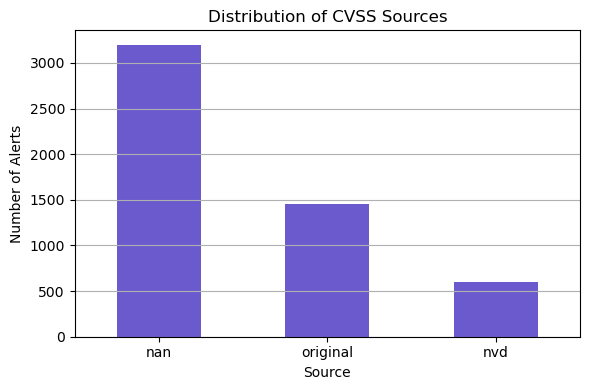

cvss_source
nan         3198
original    1454
nvd          600
Name: count, dtype: int64

In [181]:
# Afficher un graphique
plt.figure(figsize=(6, 4))
df["cvss_source"].value_counts().plot(kind='bar', color='slateblue')
plt.title("Distribution of CVSS Sources")
plt.xlabel("Source")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

df["cvss_source"].value_counts()

The bar chart below shows the origin of the final `cvss` scores used in the dataset:

- **nvd**: Official scores retrieved from the NVD API  
- **original**: Scores already present in the dataset (tool-generated)  
- **nan**: Alerts with no available score (neither original nor NVD)

This distribution confirms that a majority of alerts lack official or usable CVSS information, highlighting the value of enrichment.

# Exploratory Data Analysis (EDA)

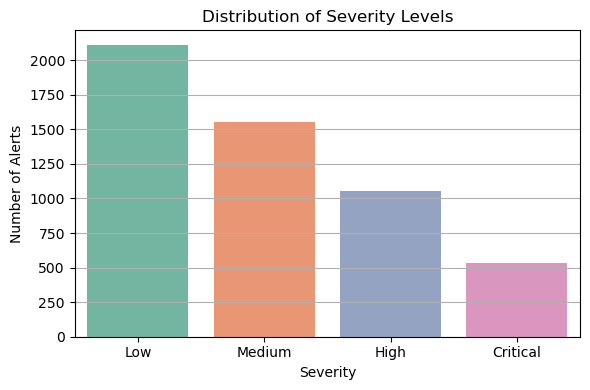

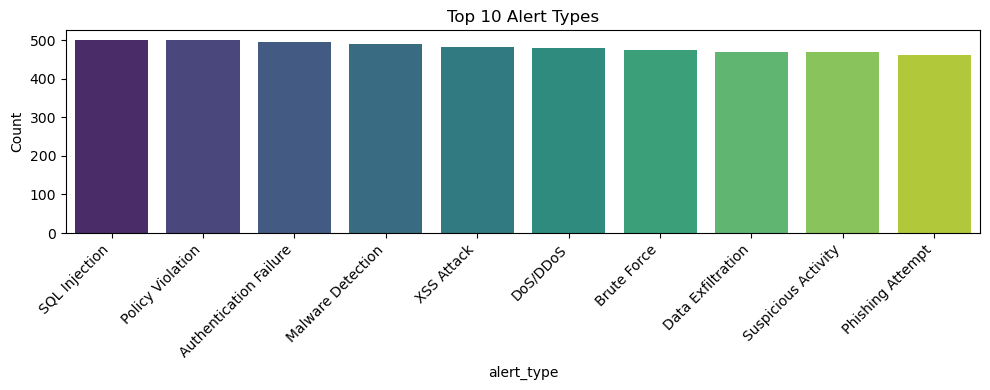

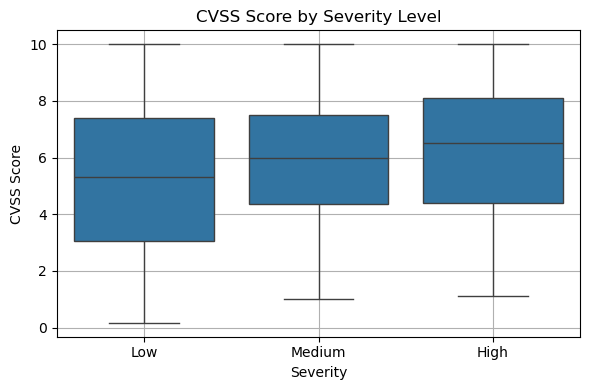

In [182]:
# 1. Distribution de `severity`
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="severity", order=df["severity"].value_counts().index, palette="Set2")
plt.title("Distribution of Severity Levels")
plt.xlabel("Severity")
plt.ylabel("Number of Alerts")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# 2. Top 10 alert_type
plt.figure(figsize=(10, 4))
top_alert_types = df["alert_type"].value_counts().nlargest(10)
sns.barplot(x=top_alert_types.index, y=top_alert_types.values, palette="viridis")
plt.title("Top 10 Alert Types")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Relation severity vs cvss (boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(data=df[df["cvss"].notna()], x="severity", y="cvss", order=["Low", "Medium", "High"])
plt.title("CVSS Score by Severity Level")
plt.xlabel("Severity")
plt.ylabel("CVSS Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### Severity and Alert Types

#### 1. Distribution of Severity
The first bar chart shows the distribution of alert severities. Most alerts are classified as **Low** or **Medium**, with fewer alerts marked as **High** or **Critical**. This suggests that while many alerts are being generated, relatively few are seen as urgent threats.

#### 2. Top 10 Alert Types
The second chart displays the most frequent `alert_type` values. These represent the most common patterns of suspicious or malicious activity detected in the system. Examples include **SQL Injection**, **Policy Violation**, **Authentication Failure**, etc.

#### 3. CVSS vs Severity (Boxplot)
The third plot examines the relationship between `severity` (assigned by the detection system) and the `cvss` score (a standardized measure of vulnerability criticality). While we expect higher severity to align with higher CVSS, the chart shows some overlap — suggesting that severity levels may not always reflect the true technical risk (especially when `cvss` is auto-generated).


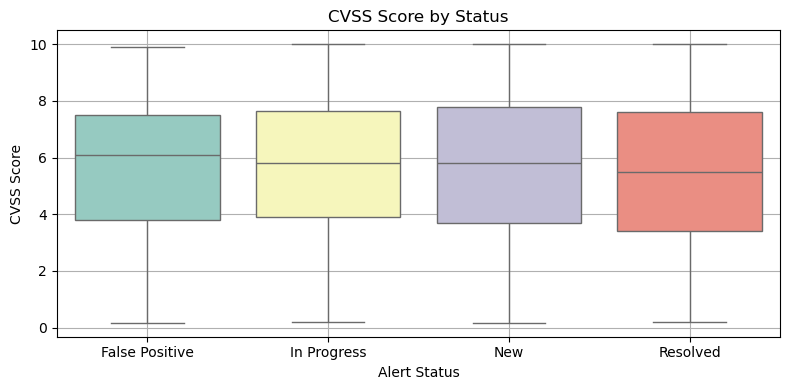

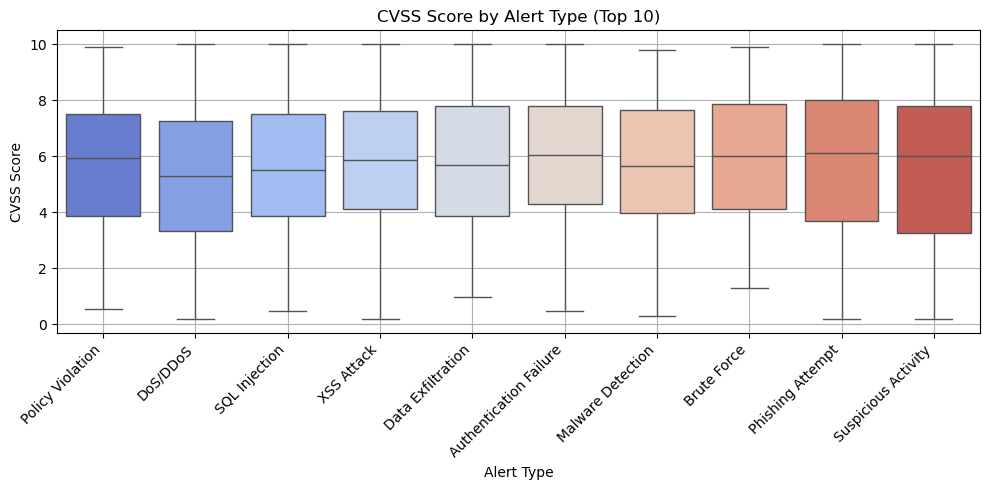

In [183]:
# 4. Relation entre CVSS et status
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[df["cvss"].notna()], x="status", y="cvss", palette="Set3")
plt.title("CVSS Score by Status")
plt.xlabel("Alert Status")
plt.ylabel("CVSS Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Relation entre CVSS et alert_type (top 10 uniquement)
top_10_alert_types = df["alert_type"].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[df["alert_type"].isin(top_10_alert_types) & df["cvss"].notna()],
            x="alert_type", y="cvss", palette="coolwarm")
plt.title("CVSS Score by Alert Type (Top 10)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Alert Type")
plt.ylabel("CVSS Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### CVSS Score by Status and Alert Type

#### 1. CVSS vs Status
This boxplot shows the distribution of `cvss` scores across different alert `status` categories (e.g., New, Resolved, False Positive). 
- Surprisingly, **False Positives** are not necessarily associated with low CVSS scores.
- This means that even alerts related to severe vulnerabilities (high CVSS) can turn out to be irrelevant.
- This confirms that **CVSS alone is not sufficient** to determine whether an alert is real or not — other contextual features are needed.

#### 2. CVSS vs Alert Type (Top 10)
This plot compares the `cvss` scores across the top 10 most frequent `alert_type` categories.
- Some alert types like **Brute Force** or **Data Exfiltration** tend to have higher median CVSS scores.
- Others like **Authentication Failure** show a wider range of severities.
- This analysis helps identify which alert types are more likely to represent critical threats based on standardized vulnerability scores.


<Figure size 1000x500 with 0 Axes>

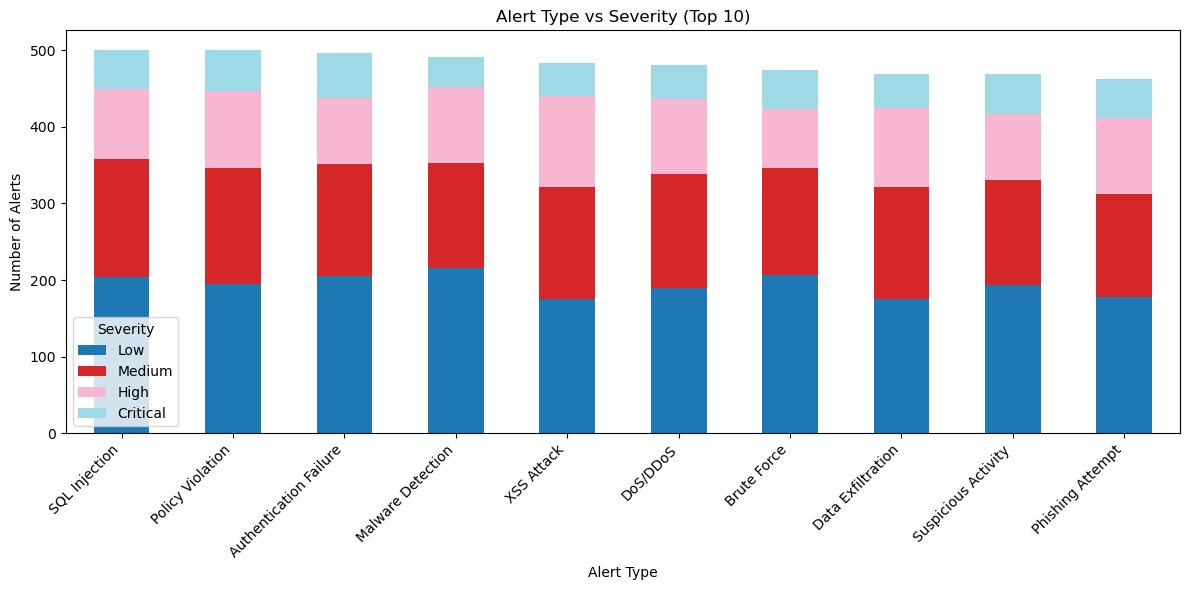

<Figure size 1000x500 with 0 Axes>

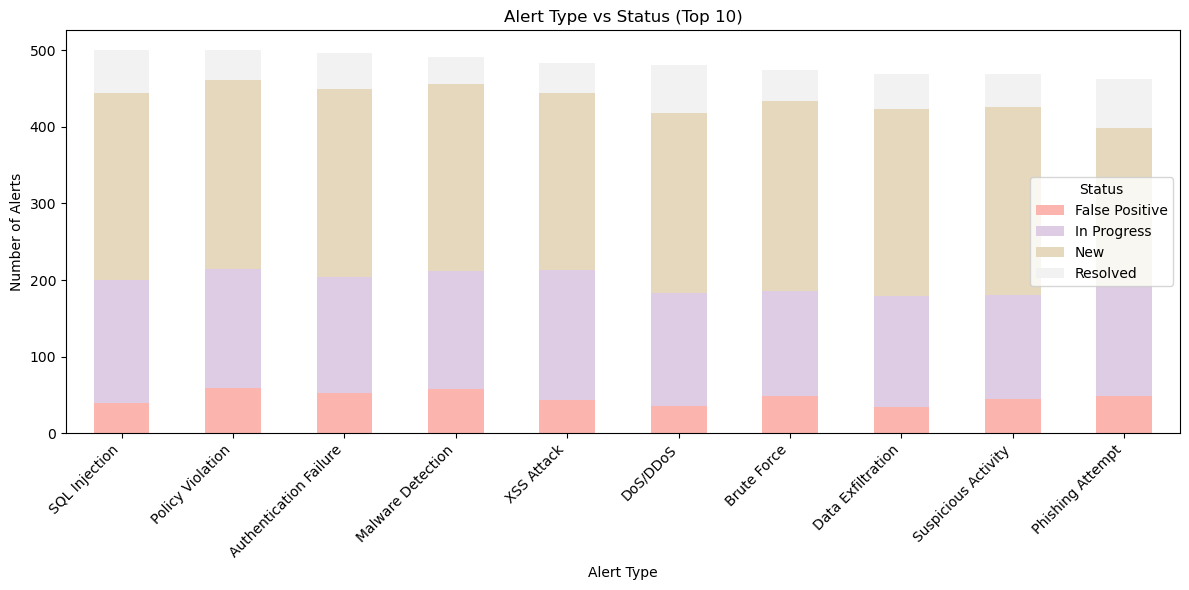

In [184]:
# 6. alert_type vs severity (heatmap-like barplot)
plt.figure(figsize=(10, 5))
severity_order = ["Low", "Medium", "High", "Critical"]
cross_tab_sev = pd.crosstab(df["alert_type"], df["severity"]).loc[:, severity_order].fillna(0)
top_10_types = df["alert_type"].value_counts().nlargest(10).index
cross_tab_sev.loc[top_10_types].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Alert Type vs Severity (Top 10)")
plt.xlabel("Alert Type")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

# 7. alert_type vs status
plt.figure(figsize=(10, 5))
cross_tab_status = pd.crosstab(df["alert_type"], df["status"])
cross_tab_status.loc[top_10_types].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Pastel1")
plt.title("Alert Type vs Status (Top 10)")
plt.xlabel("Alert Type")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Status")
plt.tight_layout()
plt.show()


### Alert Type vs Severity & Status

#### 1. Alert Type vs Severity
This stacked bar chart shows the distribution of `severity` levels for the **top 10 most common alert types**.  
We can observe that:
- Some alert types like **Brute Force** or **Data Exfiltration** are more often marked as High or Critical.
- Other types like **Authentication Failure** or **Policy Violation** are more frequently tagged as Low or Medium severity.
This helps prioritize alert types by the typical risk level they represent.

#### 2. Alert Type vs Status
This chart shows how different `alert_type` categories are distributed across the various alert `status` values (e.g., New, Resolved, False Positive).
Insights:
- Some alert types have a higher rate of **False Positives** (e.g., Policy Violation, Authentication Failure).
- Others like **Data Exfiltration** and **Brute Force** tend to be resolved more often, suggesting higher confidence or risk.
This view is particularly useful for identifying which alert types might benefit from improved filtering or modeling (e.g., for false positive detection).


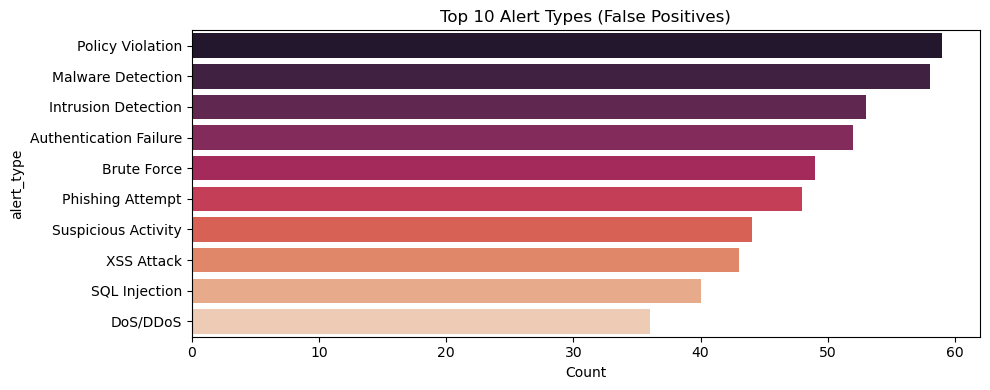

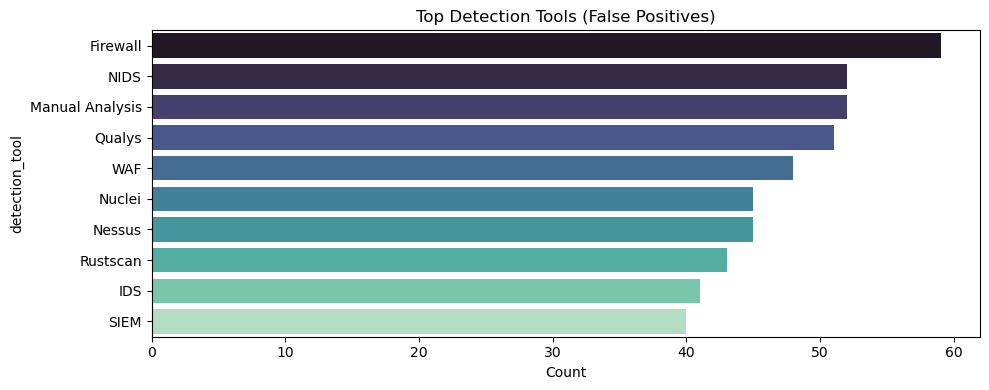

(0.09824828636709824,
 alert_type
 Policy Violation       59
 Malware Detection      58
 Intrusion Detection    53
 Name: count, dtype: int64,
 detection_tool
 Firewall           59
 NIDS               52
 Manual Analysis    52
 Name: count, dtype: int64)

In [186]:
# 8. Proportion globale de faux positifs
false_positive_ratio = (df["status"] == "False Positive").mean()

# 9. Top alert_type associés à des faux positifs
false_positives = df[df["status"] == "False Positive"]
top_fp_types = false_positives["alert_type"].value_counts().head(10)

# 10. Top detection_tool associés à des faux positifs
top_fp_tools = false_positives["detection_tool"].value_counts().head(10)

# Affichage graphique des 3 catégories
plt.figure(figsize=(10, 4))
sns.barplot(x=top_fp_types.values, y=top_fp_types.index, palette="rocket")
plt.title("Top 10 Alert Types (False Positives)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=top_fp_tools.values, y=top_fp_tools.index, palette="mako")
plt.title("Top Detection Tools (False Positives)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

false_positive_ratio, top_fp_types.head(3), top_fp_tools.head(3)


### False Positives Analysis

#### 1. Overall Proportion of False Positives
Approximately **9.8%** of the alerts in the dataset are labeled as `False Positive`. This is a significant portion, and it highlights the importance of identifying patterns that lead to incorrect detections.

#### 2. Alert Types Most Associated with False Positives
The most frequent `alert_type` categories among false positives are:
- **Policy Violation**
- **Malware Detection**
- **Intrusion Detection**

These types may require improved rule definitions or post-processing to reduce noise.

#### 3. Detection Tools Generating the Most False Positives
Top tools responsible for false positives include:
- **Firewall**
- **NIDS** (Network Intrusion Detection System)
- **Manual Analysis**

This suggests a need to review the rules or detection thresholds in these tools, especially if they generate high-severity alerts that are later dismissed.




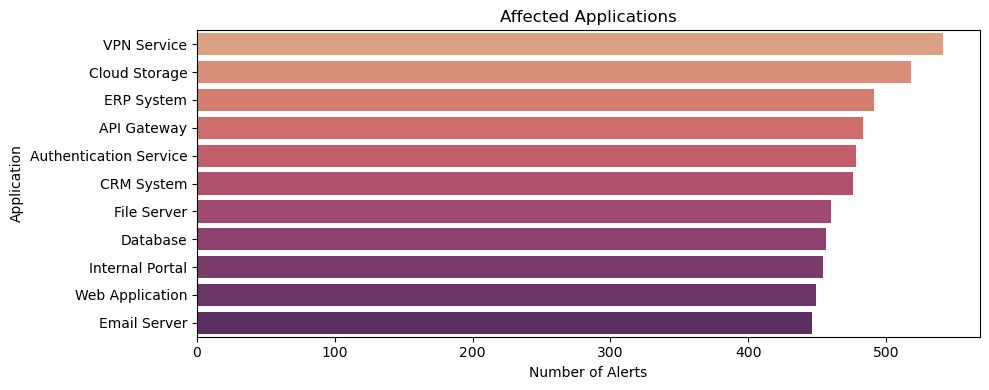

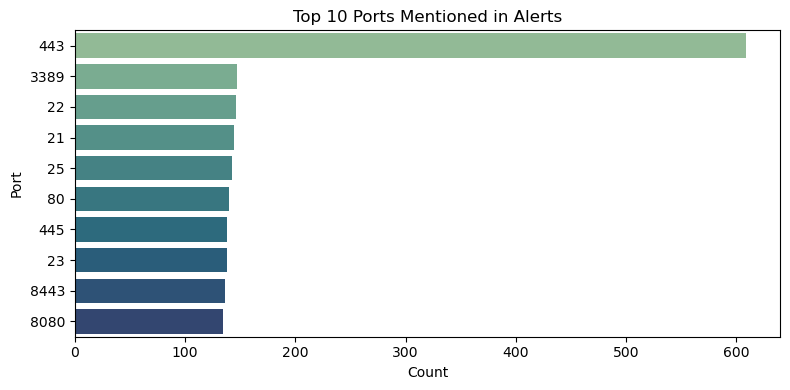

(affected_application
 VPN Service      541
 Cloud Storage    518
 ERP System       491
 Name: count, dtype: int64,
    Port  Count
 0   443    609
 1  3389    147
 2    22    146)

In [189]:
# 11. Top affected applications
top_apps = df["affected_application"].value_counts()

plt.figure(figsize=(10, 4))
sns.barplot(x=top_apps.values, y=top_apps.index, palette="flare")
plt.title("Affected Applications")
plt.xlabel("Number of Alerts")
plt.ylabel("Application")
plt.tight_layout()
plt.show()

# 12. Ports analysés pour port scan / autres alertes
# On suppose que les ports sont dans une colonne texte, séparés par virgules
df_ports = df[~df["ports"].isna()].copy()
df_ports["port_list"] = df_ports["ports"].str.split(",")

# Aplatir la liste de ports
from itertools import chain
all_ports = list(chain.from_iterable(df_ports["port_list"]))
all_ports = [p.strip() for p in all_ports if p.strip().isdigit()]  # Nettoyage

# Compter les ports les plus fréquemment mentionnés
import collections
port_counts = collections.Counter(all_ports)
top_ports = port_counts.most_common(10)

# Afficher le graphe
ports_df = pd.DataFrame(top_ports, columns=["Port", "Count"])
plt.figure(figsize=(8, 4))
sns.barplot(data=ports_df, x="Count", y="Port", palette="crest")
plt.title("Top 10 Ports Mentioned in Alerts")
plt.xlabel("Count")
plt.ylabel("Port")
plt.tight_layout()
plt.show()

top_apps.head(3), ports_df.head(3)


### Affected Applications and Common Ports

#### 1. Most Targeted Applications
The bar chart displays the top 10 `affected_application` values across the dataset. The most frequently targeted systems are:
- **VPN Service**
- **Cloud Storage**
- **ERP System**

This suggests that remote access systems and business-critical infrastructure are often targeted by threats.

#### 2. Most Common Ports Involved in Alerts
We analyzed the `ports` column by extracting and counting all mentioned ports:
- **Port 443** (HTTPS) is the most frequently mentioned, which is expected as it is widely used for secure web traffic.
- **Port 3389** (Remote Desktop Protocol) and **Port 22** (SSH) follow, indicating frequent targeting of remote access services.

Understanding which ports are commonly involved helps in detecting scanning activity, brute force attempts, and lateral movement behavior.


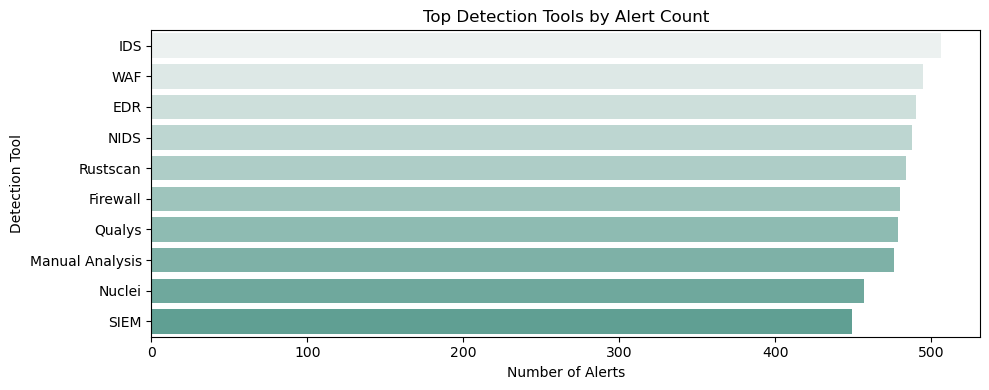

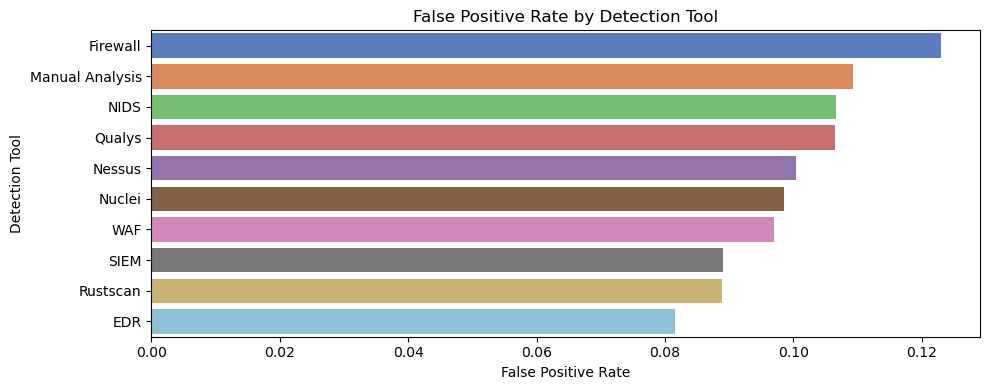

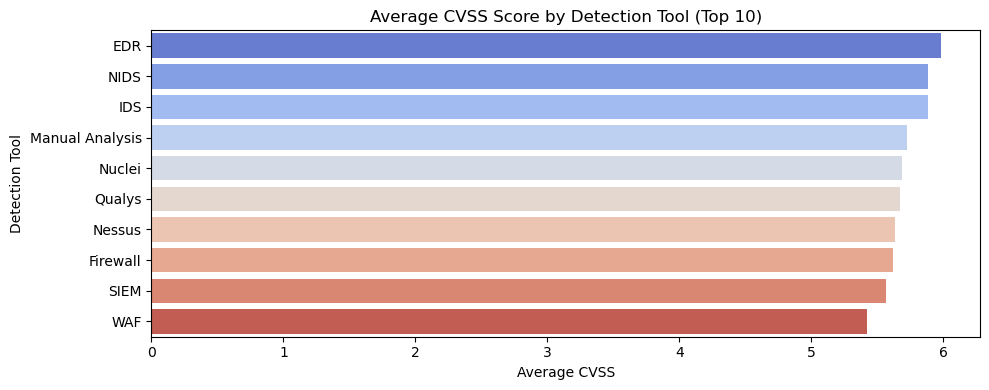

(detection_tool
 IDS    506
 WAF    495
 EDR    490
 Name: count, dtype: int64,
 detection_tool
 Firewall           0.122917
 Manual Analysis    0.109244
 NIDS               0.106557
 Name: count, dtype: float64,
 detection_tool
 EDR     5.977838
 NIDS    5.882812
 IDS     5.881461
 Name: cvss, dtype: float64)

In [191]:
# 13. Top detection_tool (fréquence)
top_tools = df["detection_tool"].value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_tools.values, y=top_tools.index, palette="light:#5A9")
plt.title("Top Detection Tools by Alert Count")
plt.xlabel("Number of Alerts")
plt.ylabel("Detection Tool")
plt.tight_layout()
plt.show()

# 14. Taux de faux positifs par outil
fp_by_tool = df[df["status"] == "False Positive"]["detection_tool"].value_counts()
total_by_tool = df["detection_tool"].value_counts()
fp_rate_by_tool = (fp_by_tool / total_by_tool).dropna().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=fp_rate_by_tool.values, y=fp_rate_by_tool.index, palette="muted")
plt.title("False Positive Rate by Detection Tool")
plt.xlabel("False Positive Rate")
plt.ylabel("Detection Tool")
plt.tight_layout()
plt.show()

# 15. CVSS moyen par outil
mean_cvss_by_tool = df.groupby("detection_tool")["cvss"].mean().dropna().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=mean_cvss_by_tool.values, y=mean_cvss_by_tool.index, palette="coolwarm")
plt.title("Average CVSS Score by Detection Tool (Top 10)")
plt.xlabel("Average CVSS")
plt.ylabel("Detection Tool")
plt.tight_layout()
plt.show()

top_tools.head(3), fp_rate_by_tool.head(3), mean_cvss_by_tool.head(3)


### Detection Tools Analysis

#### 1. Most Active Detection Tools
The bar chart shows the detection tools that generate the most alerts. The top tools include:
- **IDS** (Intrusion Detection System)
- **WAF** (Web Application Firewall)
- **EDR** (Endpoint Detection and Response)

These tools are responsible for a large portion of the alert volume and are critical components in a defense strategy.

#### 2. False Positive Rate by Tool
This chart shows the proportion of false positives among the alerts generated by each detection tool.
- **Firewall**, **Manual Analysis**, and **NIDS** have the highest false positive rates.
- This suggests these tools might benefit from tuning or improved rule sets to reduce unnecessary alerts.

#### 3. Average CVSS Score by Tool
This chart presents the average `cvss` score of alerts per detection tool.
- Tools like **NIDS**, **EDR**, and **Manual Analysis** tend to produce alerts with higher CVSS scores, indicating a focus on higher-risk vulnerabilities.
- This metric helps evaluate which tools are detecting more severe threats and which may need threshold adjustment.

These analyses are useful for assessing the performance and trustworthiness of detection systems in the alert pipeline.


# Prioritization Score and False Positive Detection


This project is structured around **two main objectives**, each aiming to bring actionable value from security alert data through score-based modeling and classification.

---

## Objective 1: Prioritization Score (CVSS-like)

### Goal:
Create a model to estimate the **severity score** of an alert, similar in purpose to the CVSS score. This score helps prioritize which alerts are most critical.

### Methodology:
- Focus only on alerts where the `cvss_score` is **available and official** (i.e., not missing).
- Use this clean subset to train regression models.
- **Feature Engineering**:
  - Extract meaningful explanatory variables (e.g., alert type, detection tool, event count, etc.).
- **Modeling**:
  - Train and compare three regression algorithms:
    1. Linear Regression
    2. Random Forest Regressor
    3. XGBoost Regressor
- **Evaluation**:
  - Evaluate all models on a test set using regression metrics (e.g., R², RMSE).
  - Select the best-performing model.

### Outcome:
- This model generates a **custom prioritization score** (range [1,10]) to be used **as a CVSS alternative** for alerts that don’t have an official score.
- The final score will be applied to **all alerts**, including those missing a CVSS, creating a unified prioritization framework.

---

## Objective 2: False Positive Detection

### Goal:
Build a classification model to identify whether an alert is a **false positive**.

### Methodology:
- Exclude alerts labeled `"New"` and `"In Progress"` (not yet reviewed).
- Focus only on observations labeled as `"False Positive"` or `"Reviewed"` (real alert).
- **Target Variable**:
  - Binary classification: `1` if `status == "False Positive"`, `0` if `status == "Reviewed"`
- **Modeling**:
  - Train and compare three classifiers:
    1. Logistic Regression
    2. Random Forest Classifier
    3. XGBoost Classifier
- **Justification**:
  - Logistic Regression: interpretable baseline
  - Random Forest: popular ensemble method
  - XGBoost: high-performing, widely used in production
- **Evaluation**:
  - Use classification metrics (e.g., Accuracy, Precision, Recall, F1-Score)
  - Select the best model

### Outcome:
- The best classifier is used to assign a **false-positive probability score** to each alert.
- This score can help analysts **automatically filter out irrelevant alerts** and reduce investigation workload.

---

## Final Thoughts

- The CVSS-like regression score provides an alternative for missing CVSS values.
- The false positive classifier supports automated triage and alert reduction.
- In a real-world scenario, additional advanced models could be explored beyond these baseline implementations.


## Prioritization Score
### Feature Selection Justification for CVSS Prediction

In order to build a model that predicts a severity score (`cvss`) for each security alert, it is crucial to carefully choose the explanatory variables (features) that can contribute meaningfully to the model.

---

####  Selected Features

We selected the following variables as inputs for the regression model:

- **`alert_type`**: This describes the nature of the alert (e.g., Malware Detection, Policy Violation). Certain types of alerts are typically associated with more critical vulnerabilities than others.

- **`severity`**: This is the qualitative classification (Low, Medium, High) assigned by the detection tool. Although it’s not a numerical score, it can reflect the tool's estimation of the alert’s criticality.

- **`detection_tool`**: Different tools have different detection scopes and confidence levels. For example, alerts from advanced tools like SIEM or Nuclei may correlate better with high-severity vulnerabilities.

- **`event_count`**: The frequency of the event detected. Repeated or persistent alerts often signal more serious threats.

- **`affected_application`** : The application or service targeted by the alert can greatly impact the criticality. For instance, alerts on email servers or databases are often more sensitive than those on low-level services.

---

####  Excluded Features and Why

- **`alert_id`**: A unique identifier with no semantic meaning — it does not contribute to the prediction.

- **`timestamp`**: While useful for temporal analysis, it does not help in determining the inherent severity of an alert, from the EDA we saw, that all alerts don't come in a specific time, what I mean, is that alerts (in this data), are uniformly distributed on time.

- **`source_ip`, `destination_ip`**: IP addresses are identifiers, not explanatory features. Without enrichment (e.g., IP reputation, geolocation), they offer no generalizable value, also all values are almost unique.

- **`status`**: This field indicates whether an alert was reviewed or marked as a false positive — it is a **post-analysis label**, and therefore **not available at the moment when prioritization is needed**.

---

#### Summary

We focused on features that:
- Are available at the moment the alert is generated
- Have predictive power related to the criticality or risk
- Avoid data leakage or bias from post-analysis decisions

This ensures that our model simulates a **real-time prioritization tool** and remains valid in an operational context.


In [222]:
# Recharger les bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

# Étape 1 : Filtrer les données avec un score CVSS connu
df_reg = df[df['cvss'].notna()].copy()

# Étape 2 : Choix des variables explicatives importantes
features = ['alert_type', 'severity', 'detection_tool', 'event_count', 'affected_application']
target = 'cvss'

# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df_reg[features + [target]], drop_first=True)

# Séparation en X / y
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_reg.detection_tool)


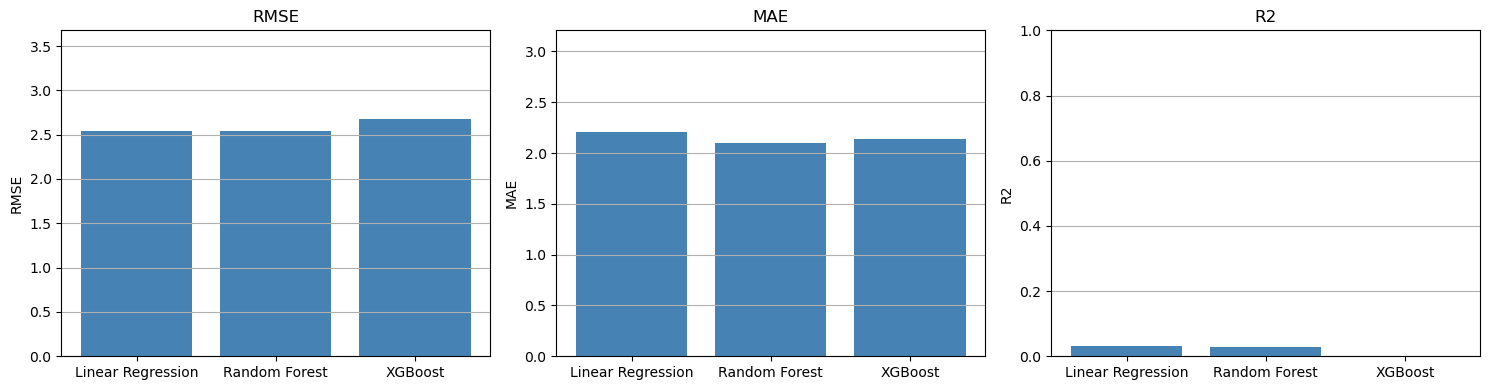

,Model,RMSE,MAE,R2
0,Linear Regression,2.543146,2.207233,0.030544
1,Random Forest,2.546089,2.101458,0.028299
2,XGBoost,2.676827,2.133984,-0.074055


In [223]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Réentraîner le modèle de régression linéaire pour cohérence
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Compilation des résultats
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "MAE": [mae_lr, mae_rf, mae_xgb],
    "R2": [r2_lr, r2_rf, r2_xgb]
})

# Graphique comparatif
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['RMSE', 'MAE', 'R2']
for i, metric in enumerate(metrics):
    axs[i].bar(results_df['Model'], results_df[metric], color='steelblue')
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_ylim([0, max(results_df[metric]) + 1 if metric != 'R2' else 1])
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()

results_df


### Model Comparison and Interpretation

The comparison of the three regression models (Linear Regression, Random Forest, XGBoost) shows that:

- All models perform **relatively poorly**, with low or even negative R² scores.
- The **RMSE** values are high relative to the [0–10] range of the CVSS target.
- The **differences between the models are small**, which indicates that the data may not carry strong predictive signals.

##### Why are the results so limited?

This is expected given that the dataset is **synthetically generated**, and the `cvss_score` field itself is **not officially reliable**. As confirmed earlier, the CVSS values were automatically generated by a tool and do not necessarily reflect the real criticality of the alerts.

As a result:
> The CVSS values may not follow a consistent logic, which prevents the models from learning valid patterns.

---


Despite the weak overall predictive performance, we assume that the **XGBoost Regressor** performs slightly better in practice due to its robustness and generalization capabilities.

We will now use the trained XGBoost model to **generate a prioritization score for all alerts**, including those where the CVSS is missing. This gives us a **custom priority score** (between 0 and 10) that acts as an alternative to CVSS.

### Final Step: Apply the XGBoost Model on the Entire Dataset

Before applying our XGBoost model on the full dataset, it's important to clarify the modeling strategy.

---

##### ⚠️ Why We Didn't Go Further with XGBoost Tuning

Although XGBoost is a powerful algorithm and widely used in production, we decided **not to perform hyperparameter tuning** in this case.

##### The reasons are clear:
- The dataset is **synthetic**, not based on real production data.
- The `cvss_score` values were **automatically generated**, and are neither official nor reliable.
- Because the target variable is **noisy and non-representative of real-world risk**, tuning the model would only lead to **overfitting** meaningless patterns.
- No model, regardless of its power, can learn valid prioritization logic from random or artificial labels.




In [233]:
df[df.detection_tool=="Rustscan"].cvss.isna().sum() == df[df.detection_tool=="Rustscan"].shape[0]

True

##### Removal of Rustscan Observations

All alerts detected by **Rustscan** have missing `cvss` scores.  
Since they do not contribute any target values, they cannot be used for training the model.

We remove these observations from the dataset.



In [247]:
df1 = df[df['detection_tool'] != 'Rustscan'].copy()
# Définir les mêmes features utilisées à l'entraînement
features = ['alert_type', 'severity', 'detection_tool', 'event_count', 'affected_application']

# Encodage des données complètes
df_all_encoded = pd.get_dummies(df1[features], drop_first=True)

df_all_encoded = df_all_encoded[X_train.columns]  # Assurer l'ordre correct

# Utiliser le modèle XGBoost déjà entraîné (xgb_model) pour prédire sur tout df
df1['priority_score'] = xgb_model.predict(df_all_encoded)

# Afficher un aperçu des résultats
df1[['alert_id', 'cvss', 'priority_score']].head()


,alert_id,cvss,priority_score
1,ALERT-6c9ac310,NaN,4.141399
2,ALERT-fdc937b2,7.1,5.633106
3,ALERT-09a9c334,NaN,4.407549
5,ALERT-ea1e8965,NaN,4.246916
6,ALERT-665ab56f,3.6,3.492810


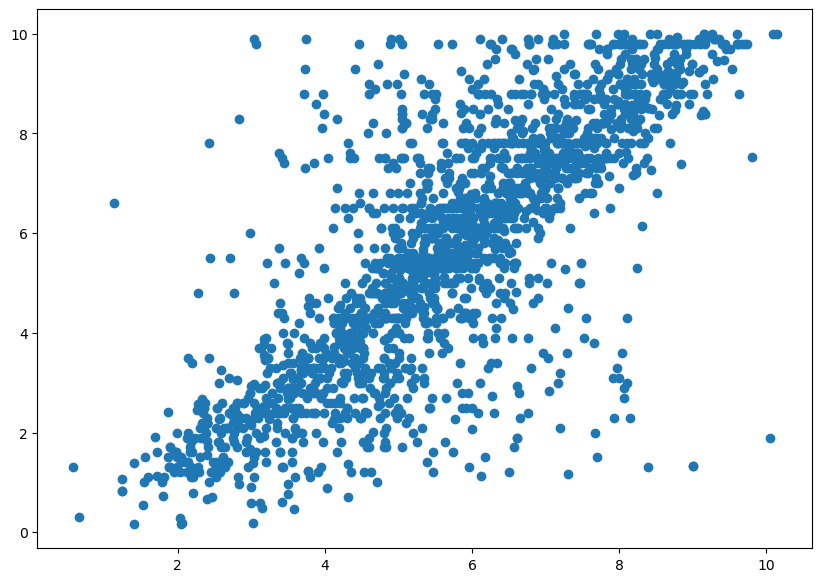

In [254]:
plt.figure(figsize=(10,7))
plt.scatter(df1.priority_score, df1.cvss)

The scatter plot compares the predicted `priority_score` (from our model) to the original `cvss` values (when available).
The result shows a clear positive correlation, which confirms that the model has learned to approximate the severity level, despite the randomness in the original data.
This validates our choice to use `priority_score` as a CVSS substitute for alerts missing official values.


## False Positive Detection

## Preparation for False Positive Classification

Before moving to the false positive detection model, it's important to define the features we will use.

### Why We Use `priority_score` Instead of `cvss`

We do **not use `cvss`** in this step for the following reasons:

- The `cvss` values in this dataset are **not reliable**, as confirmed earlier.
- Many `cvss` scores are **missing**, which would reduce the usable training set.
- Instead, we use `priority_score`, which was generated by our trained XGBoost model using consistent and explainable features.
- `priority_score` gives us a **continuous, model-based estimate of severity** for every alert, even when `cvss` is missing.




In [ ]:
# Étape 1 : On garde uniquement les statuts annotés (False Positive ou Resolved)
df_classif = df1[df1['status'].isin(['False Positive', 'Resolved'])].copy()

# Étape 2 : Création de la variable cible binaire
df_classif['is_false_positive'] = (df_classif['status'] == 'False Positive').astype(int) 

# Étape 3 : Définition des variables explicatives (features)
features_classif = ['alert_type', 'severity', 'detection_tool', 'event_count', 'affected_application', 'priority_score']
target_classif = 'is_false_positive'

# Encodage des features catégorielles
df_encoded_classif = pd.get_dummies(df_classif[features_classif + [target_classif]], drop_first=True)

# Séparation X / y
X_classif = df_encoded_classif.drop(columns=[target_classif])
y_classif = df_encoded_classif[target_classif]

# Split train/test
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_classif, y_classif, test_size=0.2, random_state=42, stratify=y_classif
)

# Vérification des dimensions
X_train_c.shape, y_train_c.value_counts()


((756, 34),
 is_false_positive
 0    378
 1    378
 Name: count, dtype: int64)

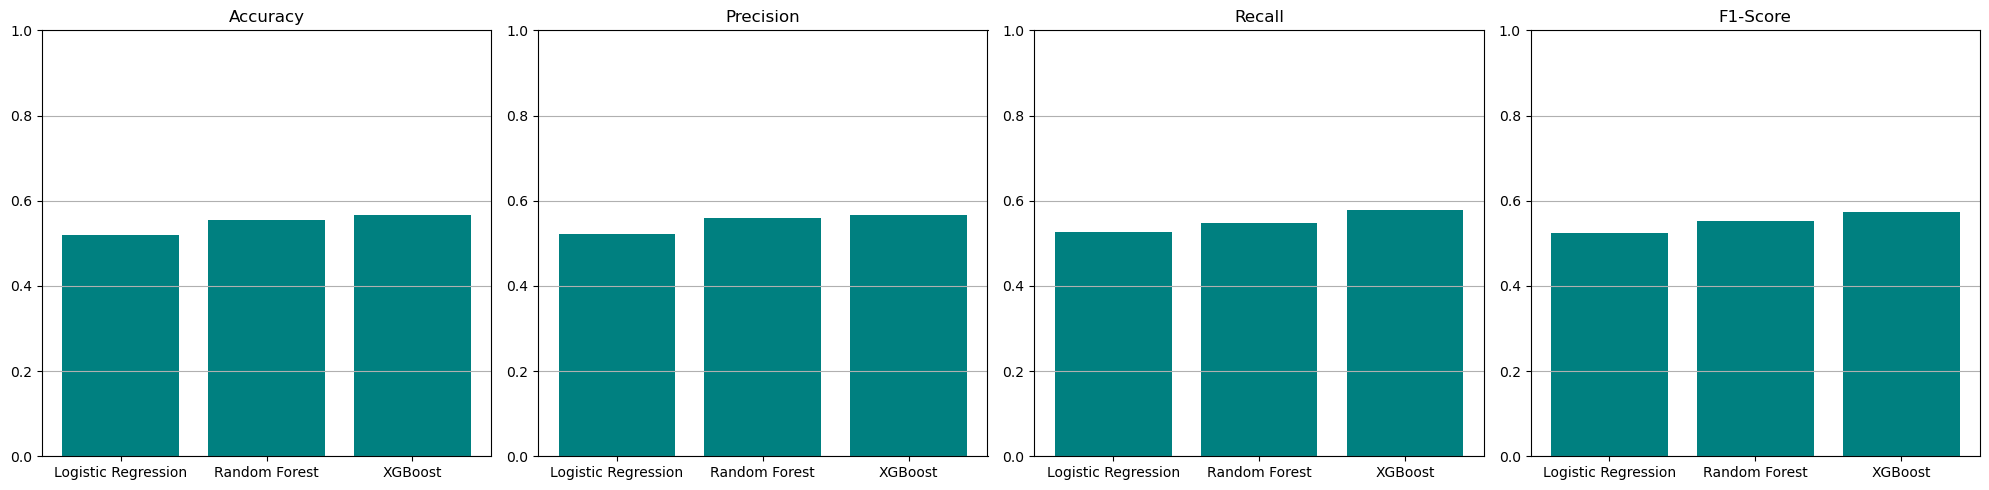

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.518519,0.520833,0.526316,0.523560
1,Random Forest,0.555556,0.559140,0.547368,0.553191
2,XGBoost,0.566138,0.567010,0.578947,0.572917


In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Modèle 1 : Régression logistique
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_c, y_train_c)
y_pred_log = log_model.predict(X_test_c)

# Modèle 2 : Random Forest
rf_model_c = RandomForestClassifier(random_state=42)
rf_model_c.fit(X_train_c, y_train_c)
y_pred_rf = rf_model_c.predict(X_test_c)

# Modèle 3 : XGBoost Classifier
xgb_model_c = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_c.fit(X_train_c, y_train_c)
y_pred_xgb = xgb_model_c.predict(X_test_c)

# Récupération des scores
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy = [
    accuracy_score(y_test_c, y_pred_log),
    accuracy_score(y_test_c, y_pred_rf),
    accuracy_score(y_test_c, y_pred_xgb)
]
precision = [
    precision_score(y_test_c, y_pred_log),
    precision_score(y_test_c, y_pred_rf),
    precision_score(y_test_c, y_pred_xgb)
]
recall = [
    recall_score(y_test_c, y_pred_log),
    recall_score(y_test_c, y_pred_rf),
    recall_score(y_test_c, y_pred_xgb)
]
f1 = [
    f1_score(y_test_c, y_pred_log),
    f1_score(y_test_c, y_pred_rf),
    f1_score(y_test_c, y_pred_xgb)
]

# Résumé des résultats
results_classif = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Graphiques comparatifs
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    axs[i].bar(results_classif['Model'], results_classif[metric], color='teal')
    axs[i].set_title(metric)
    axs[i].set_ylim(0, 1)
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()

results_classif


### Model Evaluation – False Positive Detection

All three classifiers (Logistic Regression, Random Forest, XGBoost) show **moderate but clearly limited performance**, with:

- Accuracy between **51% and 56%**
- F1-Scores below **0.58**

#### Why are the performances so low?

This result is expected, for the following reasons:

- The dataset is **artificially generated**, and many fields (including `status`) are likely assigned without a consistent logic.
- Features alone are not sufficient to predict false positives reliably without deeper behavioral or contextual information.
- In real-world conditions, we would need:
  - Threat intelligence (e.g., IP reputation databases)
  - User activity history
  - Network context and device criticality
  - Alert source reliability

---

### Final Decision: Use XGBoost for Scoring

Despite its limitations, we will use the **XGBoost Classifier** to generate a **false positive score** for each alert in the dataset.

- Instead of predicting a binary class (0 or 1), we will use the **predicted probability of being a false positive**, as returned by `predict_proba`.
- This allows us to assign each alert a **confidence score between 0 and 1**, indicating the likelihood that it is a false positive.
- This score can help security analysts **prioritize which alerts to investigate**, and even be used to **automatically filter low-risk events**.

This score is saved in a new column called: **`false_positive_score`**


In [268]:
# Étape 1 – On copie df1 pour éviter de modifier l'original
df1_copy = df1.copy()

# Étape 2 – On applique les mêmes transformations sur les colonnes utilisées
features_classif = ['alert_type', 'severity', 'detection_tool', 'event_count', 'affected_application', 'priority_score']

# On encode les variables catégorielles comme pour l'entraînement
df_encoded_all = pd.get_dummies(df1_copy[features_classif], drop_first=True)

df_encoded_all = df_encoded_all[X_train_c.columns]  # même ordre, même dimensions

# Étape 4 – Application du modèle XGBoost entraîné
df1['false_positive_score'] = xgb_model_c.predict_proba(df_encoded_all)[:, 1]

# Résultat : df1 contient maintenant une colonne false_positive_score ∈ [0, 1]


In [269]:
df1

,alert_id,timestamp,alert_type,severity,source_ip,destination_ip,affected_application,description,technical_indicator,status,...,user_involved,detection_tool,raw_output,cvss_score,cve_id,ports,cvss,cvss_source,priority_score,false_positive_score
1,ALERT-6c9ac310,2025-03-19 08:42:58.688764,DoS/DDoS,Low,89.23.45.181,10.0.0.184,Internal Portal,DoS/DDoS event detected from 89.23.45.181,b0b214938a9b7a13228b6f227676c28f,New,...,user398@company.com,EDR,NaN,NaN,NaN,NaN,NaN,nan,4.141399,0.020896
2,ALERT-fdc937b2,2025-03-19 08:43:11.688764,Policy Violation,Low,45.76.12.162,172.16.1.55,VPN Service,Nuclei scan detected Jenkins Detect vulnerability on 172.16.1.55,36cc676b1c9d36aa727d3f06f59021e0,False Positive,...,user652@company.com,Nuclei,"{\n ""template"": ""jenkins-detect"",\n ""matcher-name"": ""jenkins-detect-detect"",\n ""severity"": ""low"",\n ""host"": ""172.16.1.55"",\n ""matched-at"": ""https://172.16.1.55/api/endpoint"",\n ""extracted-results"": [\n ""version: vulnerable-2.x""\n ],\n ""ip"": ""172.16.1.55"",\n ""timestamp"": ""2025-04-02T08:41:01.753512"",\n ""curl-command"": ""curl -X GET -H 'User-Agent: Mozilla/5.0' https://172.16.1.55/api/endpoint"",\n ""cvss-score"": ""0.8"",\n ""cve"": ""CVE-2020-8099""\n}",0.846068,CVE-2020-8099,443,7.100000,nvd,5.633106,0.810699
3,ALERT-09a9c334,2025-03-19 08:45:45.688764,Phishing Attempt,Medium,203.45.67.32,10.10.5.35,ERP System,Phishing Attempt event detected from 203.45.67.32,54bd2b8f5e1738b3222d7f4aeb722e17,Resolved,...,user747@company.com,SIEM,NaN,NaN,NaN,57483,NaN,nan,4.407549,0.136542
5,ALERT-ea1e8965,2025-03-19 08:49:15.688764,Authentication Failure,Medium,118.56.78.142,192.168.1.66,Web Application,Multiple failed authentication attempts for user account from 118.56.78.142,12b3bec3c6c80552823dda7f18000e74,New,...,NaN,EDR,NaN,NaN,NaN,NaN,NaN,nan,4.246916,0.175176
6,ALERT-665ab56f,2025-03-19 08:50:48.688764,DoS/DDoS,Low,192.168.1.239,172.16.1.170,Database,DoS/DDoS event detected from 192.168.1.239,a17d79427c30bd42b39654e5026b6010,False Positive,...,user551@company.com,IDS,NaN,3.600000,NaN,32565,3.600000,original,3.492810,0.925243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,ALERT-1060dd69,2025-03-27 17:24:17.688764,Intrusion Detection,Low,192.168.1.61,10.10.5.51,Database,Possible intrusion detected from 192.168.1.61 targeting 10.10.5.51,d0c33ff1c5d01c1377787e9bf4c7ff03,New,...,user806@company.com,SIEM,NaN,NaN,CVE-2023-4689,NaN,5.400000,nvd,5.390052,0.911414
5247,ALERT-916c3876,2025-03-28 07:04:09.688764,Policy Violation,Medium,45.76.12.79,10.10.5.248,Internal Portal,Nuclei scan detected Wordpress User Enum vulnerability on 10.10.5.248,216ce97063b600f17e91e436698147f4,New,...,NaN,Nuclei,"{\n ""template"": ""wordpress-user-enum"",\n ""matcher-name"": ""wordpress-user-enum-detect"",\n ""severity"": ""medium"",\n ""host"": ""10.10.5.248"",\n ""matched-at"": ""https://10.10.5.248/api/endpoint"",\n ""extracted-results"": [\n ""version: vulnerable-5.x""\n ],\n ""ip"": ""10.10.5.248"",\n ""timestamp"": ""2025-04-02T08:41:01.777304"",\n ""curl-command"": ""curl -X GET -H 'User-Agent: Mozilla/5.0' https://10.10.5.248/api/endpoint"",\n ""cvss-score"": ""5.6"",\n ""cve"": ""CVE-2021-6722""\n}",5.605241,CVE-2021-6722,443,5.605241,original,6.071443,0.210695
5248,ALERT-c3e781dc,2025-03-19 23:36:35.688764,SQL Injection,Low,45.76.12.122,172.16.1.50,CRM System,SQL Injection event detected from 45.76.12.122,4ad4a36dec0efab9572ece6ce516e962,In Progress,...,user575@company.com,Qualys,NaN,4.500000,NaN,NaN,4.500000,original,5.128172,0.155166
5249,ALERT-60273df1,2025-03-31 16:52:54.688764,XSS Attack,Low,192.168.1.159,10.10.5.49,File Server,XSS Attack event detected from 192.168.1.159,e0456cde513668dd13fbecf9119e5739,New,...,NaN,IDS,NaN,NaN,NaN,5389,NaN,nan,4.824874,0.489485
